In [1]:
import os 
import json
import tweepy
import networkx as nx
import pandas as pd
import numpy as np

# Load Twitter API credentials from external file

Create a json file named `twitter_credentials.json`

```
{
    "api_key": "...",
    "api_secret": "...",
    "access_token": "...",
    "access_secret": "...",
    "bearer_token": "..."
}
```

In [2]:
credentials_file = 'twitter_credentials.json'

with open(credentials_file) as credentials_data:
   api_data = json.load(credentials_data)

api_key = api_data['api_key']
api_secret = api_data['api_secret']
access_token = api_data['access_token']
access_secret = api_data['access_secret']
bearer_token = api_data['bearer_token']

In [3]:

client = tweepy.Client(
    consumer_key=api_key, 
    consumer_secret=api_secret, 
    access_token=access_token, 
    access_token_secret=access_secret, 
    bearer_token=bearer_token,
    wait_on_rate_limit=True,
    return_type=dict
)

In [4]:
accounts = ["mizzaro", "Miccighel_"]

data_folder = "data"

excluded_users_file = "excluded_usernames.json"

def serialize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    with open(f"{folder}/{filename}", 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}")

def read_json(path, verbose=True):
    if os.path.exists(path):
        with open(path, "r", encoding="utf8") as file:
            data = json.load(file)
        if verbose:
            print(f"Data read from path: {path}")
        return data
    else:
        print(f"No data found at path: {path}")
        return {}

# check if username is excluded
def is_excluded(username):
    excluded_users_data = read_json(f"{data_folder}/{excluded_users_file}", False)
    excluded_users_list = excluded_users_data['excluded']

    if username in excluded_users_list:
        return True
    else:
        return False

# add username to excluded lists
def add_to_excluded(username):
    excluded_users_data = read_json(f"{data_folder}/{excluded_users_file}", False)
    excluded_users_list = excluded_users_data['excluded']

    if username not in excluded_users_list:
        excluded_users_data['excluded'].append(username)
        serialize_json(data_folder, excluded_users_file, excluded_users_data)
    else:
        print(f"User {username} is already present in excluded list")

def get_tweetsv2(username, quantity, userid=None):
    tweets = []
    tweets_file = f"{data_folder}/{username}_tweets.json"

    data_total = quantity

    if not os.path.exists(tweets_file):
        # Get Tweets from Twitter
        if userid:
            user = {}
            user['id'] = userid
            user['username'] = username
        else:
            response = client.get_user(username=username)
            user = response['data']
        print(f"Processing user with id {user['id']} and username {user['username']}")
        # Get 5 most recent tweets
        response = client.get_users_tweets(
                    id=user['id'], tweet_fields=['created_at', 'lang', 'public_metrics'],
                    max_results=data_total
                    )
    else:
        # Get Tweets from file
        print(f"Processing user with username {username} from file")
        response = {}
        response['data'] = read_json(tweets_file)
    
    for data in response['data']:
        tweets.append(data)
    return tweets

def get_followersv2(username, quantity, userid=None, save_all=True):
    followers_of_user = []
    all_followers_of_user = []
    all_followers_file = f"{data_folder}/{username}_followers.json"

    data_for_page = 1000
    data_total = quantity

    if not os.path.exists(all_followers_file):
        # Get Followers from Twitter
        if userid:
            user = {}
            user['id'] = userid
            user['username'] = username
        else:
            response = client.get_user(username=username)
            user = response['data']
        print(f"Processing user with id {user['id']} and username {user['username']}")
        # Get first 1000 followers
        response = client.get_users_followers(
                    id=user['id'], user_fields=['name', 'description', 'location', 'protected', 'public_metrics'], 
                    max_results=data_for_page
                    )
    else:
        # Get Followers from file
        print(f"Processing user with username {username} from file")
        response = {}
        response['data'] = read_json(all_followers_file)
        save_all = False
    
    for data in response['data']:
        if save_all:
            all_followers_of_user.append(data)
        # Skip excluded username
        if is_excluded(data['username']):
            continue
        if(len(followers_of_user) < data_total) and\
            not data['protected'] and\
            data['public_metrics']['tweet_count'] >= 5 and\
            5 <= data['public_metrics']['followers_count'] < 1000 and\
            5 <= data['public_metrics']['following_count'] < 1000:
            followers_of_user.append(data)
    if save_all:                
        serialize_json(data_folder, f"{username}_followers.json", all_followers_of_user)
    print(f"Found {len(followers_of_user)} followers for user {username}")
    if len(followers_of_user) < data_total:
        add_to_excluded(username)
        return []
    else:
        return followers_of_user

def get_followingv2(username, quantity, userid=None, save_all=False):
    following_of_user = []
    all_following_of_user = []
    all_following_file = f"{data_folder}/{username}_following.json"

    data_for_page = 1000
    data_total = quantity

    if not os.path.exists(all_following_file):
        # Get Following from Twitter
        if userid:
            user = {}
            user['id'] = userid
            user['username'] = username
        else:
            response = client.get_user(username=username)
            user = response['data']
        print(f"Processing user with id {user['id']} and username {user['username']}")
        # Get first 1000 following
        response = client.get_users_following(
                    id=user['id'], user_fields=['protected', 'public_metrics'], 
                    max_results=data_for_page
                    )
    else:
        # Get Following from file
        print(f"Processing user with username {username} from file")
        response = {}
        response['data'] = read_json(all_following_file)
        save_all = False
    
    for data in response['data']:
        if save_all:
            all_following_of_user.append(data)
        # Skip excluded username
        if is_excluded(data['username']):
            continue
        if(len(following_of_user) < data_total) and\
            not data['protected'] and\
            data['public_metrics']['tweet_count'] >= 5 and\
            5 <= data['public_metrics']['followers_count'] < 1000 and\
            5 <= data['public_metrics']['following_count'] < 1000:
            following_of_user.append(data)
    if save_all:                
        serialize_json(data_folder, f"{username}_following.json", all_following_of_user)
    print(f"Found {len(following_of_user)} following of user {username}")
    if len(following_of_user) < data_total:
        add_to_excluded(username)
        return []
    else:
        return following_of_user

# First level followers

In [5]:

first_level_followers = []
for account in accounts:
    # Get 5 followers and save all followers list
    first_level_followers.extend(get_followersv2(account, 5))
    
serialize_json(data_folder, "first_level_followers.json", first_level_followers)

Processing user with username mizzaro from file
Data read from path: data/mizzaro_followers.json
Found 5 followers for user mizzaro
Processing user with username Miccighel_ from file
Data read from path: data/Miccighel__followers.json
Found 5 followers for user Miccighel_
Data serialized to path: data/first_level_followers.json


# First level following

In [6]:

first_level_following = []
for account in accounts:
    # Get 5 following and save all following list
    first_level_following.extend(get_followingv2(account, 5))
    
serialize_json(data_folder, "first_level_following.json", first_level_following)

Processing user with username mizzaro from file
Data read from path: data/mizzaro_following.json
Found 5 following of user mizzaro
Processing user with username Miccighel_ from file
Data read from path: data/Miccighel__following.json
Found 5 following of user Miccighel_
Data serialized to path: data/first_level_following.json


# Second level followers

In [39]:
second_level_followers = []

# Get followers from first-level-followers
first_level_followers_list = read_json(f"{data_folder}/first_level_followers.json")

for follower in first_level_followers_list:
    # Get 5 followers and save all followers list - we need all information about follower leafs
    second_level_followers.extend(get_followersv2(follower['username'], 5, follower['id']))
        
# Get followers from first-level-following
first_level_following_list = read_json(f"{data_folder}/first_level_following.json")

for following in first_level_following_list:
    # Get 5 followers and do not save all followers list - we do not need information about following leafs
    second_level_followers.extend(get_followersv2(following['username'], 5, following['id'], False))

serialize_json(data_folder, "second_level_followers.json", second_level_followers)

Data read from path: data/first_level_followers.json
Processing user with username OlegZendel from file
Data read from path: data/OlegZendel_followers.json
Found 5 followers for user OlegZendel
Processing user with username LyndaSaidLhadj from file
Data read from path: data/LyndaSaidLhadj_followers.json
Found 5 followers for user LyndaSaidLhadj
Processing user with username acai2021 from file
Data read from path: data/acai2021_followers.json
Found 5 followers for user acai2021
Processing user with username rodger_benham from file
Data read from path: data/rodger_benham_followers.json
Found 5 followers for user rodger_benham
Processing user with username ColoursRiot from file
Data read from path: data/ColoursRiot_followers.json
Found 5 followers for user ColoursRiot
Processing user with username Outsider289 from file
Data read from path: data/Outsider289_followers.json
Found 5 followers for user Outsider289
Processing user with username mizzaro from file
Data read from path: data/mizzar

# Second level following

In [6]:
second_level_following = []

# Get following from first-level-followers
first_level_followers_list = read_json(f"{data_folder}/first_level_followers.json")

for follower in first_level_followers_list:
    # Get 5 following and save all followings list - we need all information about follower leafs
    second_level_following.extend(get_followingv2(follower['username'], 5, follower['id'], True))

# Get following from first-level-following
first_level_following_list = read_json(f"{data_folder}/first_level_following.json")

for following in first_level_following_list:
    # Get 5 following and do not save all followers list - we do not need information about following leafs
    second_level_following.extend(get_followingv2(following['username'], 5, following['id']))

serialize_json(data_folder, "second_level_following.json", second_level_following)

Data read from path: data/first_level_followers.json
Processing user with username OlegZendel from file
Data read from path: data/OlegZendel_following.json
Found 5 following of user OlegZendel
Processing user with username LyndaSaidLhadj from file
Data read from path: data/LyndaSaidLhadj_following.json
Found 5 following of user LyndaSaidLhadj
Processing user with username acai2021 from file
Data read from path: data/acai2021_following.json
Found 5 following of user acai2021
Processing user with username rodger_benham from file
Data read from path: data/rodger_benham_following.json
Found 5 following of user rodger_benham
Processing user with username ColoursRiot from file
Data read from path: data/ColoursRiot_following.json
Found 5 following of user ColoursRiot
Processing user with username Outsider289 from file
Data read from path: data/Outsider289_following.json
Found 5 following of user Outsider289
Processing user with username mizzaro from file
Data read from path: data/mizzaro_foll

# Last 5 tweets of first and second level followers

In [7]:
# Get tweets from first-level-followers
first_level_followers_list = read_json(f"{data_folder}/first_level_followers.json")

for follower in first_level_followers_list:
    if not os.path.exists(f"{data_folder}/{follower['username']}_tweets.json"):
        tweets = get_tweetsv2(follower['username'], 5, follower['id'])
        serialize_json(data_folder, f"{follower['username']}_tweets.json", tweets)

# Get tweets from second-level-followers
second_level_followers_list = read_json(f"{data_folder}/second_level_followers.json")

for follower in second_level_followers_list:
    if not os.path.exists(f"{data_folder}/{follower['username']}_tweets.json"):
        tweets = get_tweetsv2(follower['username'], 5, follower['id'])
        serialize_json(data_folder, f"{follower['username']}_tweets.json", tweets)

Data read from path: data/first_level_followers.json
Data read from path: data/second_level_followers.json
Processing user with id 1097014327289073664 and username Nolongerscot
Data serialized to path: data/Nolongerscot_tweets.json
Processing user with id 990463569291595776 and username arian_ask
Data serialized to path: data/arian_ask_tweets.json


# Third level followers and following

In [8]:
# Get all followers from second-level-followers
third_level_followers = []
for follower in second_level_followers_list:
    # Save all followers list - we need all information about follower leafs
    third_level_followers.extend(get_followersv2(follower['username'], 0, follower['id']))

# Get all following from second-level-followers
third_level_following = []
for follower in second_level_followers_list:
    # Save all following list - we need all information about follower leafs
    third_level_following.extend(get_followingv2(follower['username'], 0, follower['id'], True))

Processing user with username Marwah_k from file
Data read from path: data/Marwah_k_followers.json
Found 0 followers for user Marwah_k
Processing user with username ivrik from file
Data read from path: data/ivrik_followers.json
Found 0 followers for user ivrik
Processing user with username ameertawfik from file
Data read from path: data/ameertawfik_followers.json
Found 0 followers for user ameertawfik
Processing user with username aleksbobic from file
Data read from path: data/aleksbobic_followers.json
Found 0 followers for user aleksbobic
Processing user with username debforit from file
Data read from path: data/debforit_followers.json
Found 0 followers for user debforit
Processing user with username gael_dias from file
Data read from path: data/gael_dias_followers.json
Found 0 followers for user gael_dias
Processing user with username Nthakur20 from file
Data read from path: data/Nthakur20_followers.json
Found 0 followers for user Nthakur20
Processing user with username AthmaniAmine 

# Create nodes with all attributes (id, profile details, 5 tweets, public metrics)

In [9]:
import itertools 
nodes = []

for follower in itertools.chain(first_level_followers_list, second_level_followers_list):
    node_attributes = {}
    node_attributes['username'] = follower['username']
    node_attributes['name'] = follower['name']
    node_attributes['location'] = follower['location'] if 'location' in follower else None
    node_attributes['metrics'] = follower['public_metrics']
    node_attributes['tweets'] = read_json(f"{data_folder}/{follower['username']}_tweets.json", False)
    nodes.append((follower['id'], node_attributes))

# Create Social Network Graph

In [56]:
from pyvis.network import Network

# Add project members name as attribute of the graph
graph = nx.MultiDiGraph(members=['Agrate Giulio','Bibalo Simone','De Nardi Gianluca Giuseppe Maria','Giunta Marco'])

graph.add_nodes_from(nodes)

# Add egdes with following or follower attribute
for node in graph.nodes:
    user_followers = read_json(f"{data_folder}/{graph.nodes[node]['username']}_followers.json", False)
    for follower in user_followers:
        if graph.has_node(follower['id']):
            graph.add_edge(node, follower['id'], key='follower', title=f"follower - {graph.nodes[node]['username']} -> {follower['username']}")
    user_following = read_json(f"{data_folder}/{graph.nodes[node]['username']}_following.json", False)
    for following in user_following:
        if graph.has_node(following['id']):
            graph.add_edge(node, following['id'], key='following', title=f"following - {graph.nodes[node]['username']} <- {following['username']}", color='#DB6400')

nt = Network(
    height="100%", 
    width="100%", 
    bgcolor="#222222", 
    font_color="white",
    heading="Social Network Graph",
    directed=True,
)

nt.set_edge_smooth('dynamic')
nt.from_nx(graph)
neighbor_map = nt.get_adj_list()
for node in nt.nodes:
    node['label'] = node['username']
    node['title'] = node['name']
    node['value'] = len(neighbor_map[node['id']])
nt.show("html/social_network_graphs.html")

# Followers network sub-graphs

In [57]:
# Get edges with follower attribute
follower_edges = [(u, v, k) for u,v,k,d in graph.edges(data=True, keys=True) if k == 'follower']
followers_graph = graph.edge_subgraph(follower_edges)

follower_nt = Network(
    height="100%", 
    width="100%", 
    bgcolor="#222222", 
    font_color="white",
    heading="Followers Network Graph",
    directed=True
)

follower_nt.set_edge_smooth('dynamic')
follower_nt.from_nx(followers_graph)
follower_neighbor_map = follower_nt.get_adj_list()
for node in follower_nt.nodes:
    node['label'] = node['username']
    node['title'] = node['name']
    node['value'] = len(follower_neighbor_map[node['id']])
follower_nt.show("html/follower_network_graphs.html")

# Following network sub-graphs

In [61]:
# Get edges with following attribute
following_edges = [(u,v,k) for u,v,k,d in graph.edges(data=True, keys=True) if k == 'following']
following_graph = graph.edge_subgraph(following_edges)

following_nt = Network(
    height="100%", 
    width="100%", 
    bgcolor="#222222", 
    font_color="white",
    heading="Following Network Graph",
    directed=True
)

following_nt.set_edge_smooth('dynamic')
following_nt.from_nx(following_graph)
following_neighbor_map = following_nt.get_adj_list()
for node in following_nt.nodes:
    node['label'] = node['username']
    node['title'] = node['name']
    node['value'] = len(following_neighbor_map[node['id']])
following_nt.show("html/following_network_graphs.html")

Nodes:  90
Edges:  269
Average degree:  2.988888888888889
SCC:  28
WCC:  28


'\n#def plot_degree_distribution ():\n'

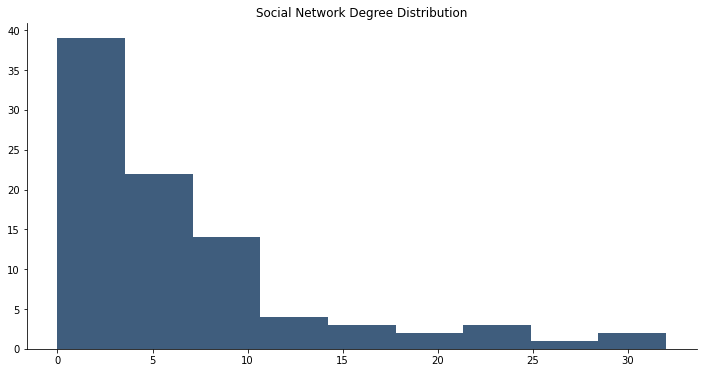

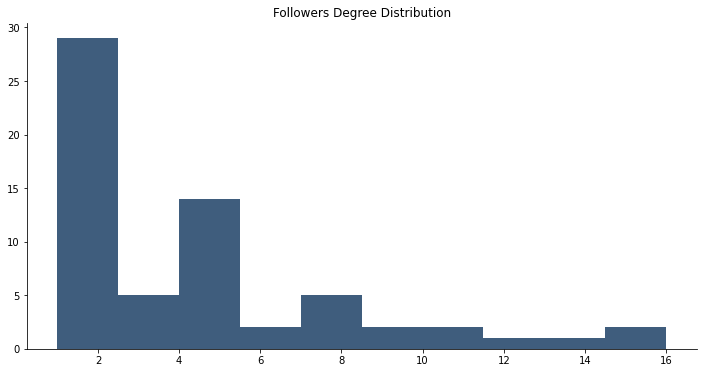

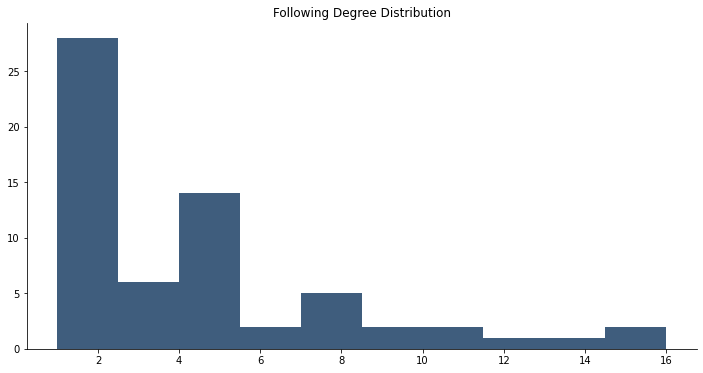

In [63]:
N, K = graph.order(), graph.size()
avg_deg = float(K) / N
print("Nodes: ", N)
print("Edges: ", K)
print("Average degree: ", avg_deg)
print("SCC: ", nx.number_strongly_connected_components(graph))
print("WCC: ", nx.number_weakly_connected_components(graph))

# Not necessary, but will be used later:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


degs = [i[1] for i in graph.degree()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.hist(degs, color="#3F5D7D", bins='auto');
plt.title("Social Network Degree Distribution")

degs = [i[1] for i in followers_graph.degree()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.hist(degs, color="#3F5D7D", bins='auto');
plt.title("Followers Degree Distribution")

degs = [i[1] for i in following_graph.degree()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.spines["top"].set_visible(False) # Remove plot frame line on the top 
ax.spines["right"].set_visible(False) # Remove plot frame line on the right
ax.get_xaxis().tick_bottom()  # Remove ticks on the bottom
ax.get_yaxis().tick_left()  # Remove the ticks on the left
ax.hist(degs, color="#3F5D7D", bins='auto');
plt.title("Following Degree Distribution")

in_degrees = graph.in_degree() # dictionary node:degree
in_values = sorted([d for n, d in in_degrees], reverse=True)

#import matplotlib
#matplotlib.use('Agg')
#import matplotlib.pyplot as plt
'''
#def plot_degree_distribution ():
'''



Text(0.5, 1.0, 'Wikipedia Degree Distribution')

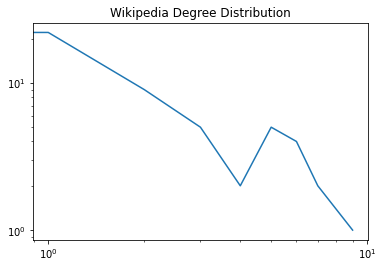

In [65]:
degs = {}
for n, d in following_graph.in_degree():
    if d not in degs:
        degs[d] = 0
    degs[d] += 1
items = sorted(degs.items())
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot([k for (k,v) in items], [v for (k, v) in items ])
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("Following Network Degree Distribution")



We can get the clustering coefficient of individual nodes or all the nodes (but first 
we need to convert the graph to an undirected one)

In [82]:

cam_net_ud = nx.DiGraph(graph).to_undirected()
#print(cam_net_ud.edges)
# Clustering coefficient of node 0
#print(nx.clustering(cam_net_ud, '998681467696885761'))
# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(cam_net_ud)
# Average clustering coefficient
avg_clust = sum(clust_coefficients.values()) / len(clust_coefficients)
print(avg_clust)
# Or use directly the built-in method
print(nx.average_clustering(cam_net_ud))

0.17587301587301588
0.17587301587301588


Misurate le seguenti distanze sui grafi:
 - Centro
 - Raggio
 - Distanza Media
 - Distanza Massima

In [102]:
# Center : This is the set of nodes whose eccentricity is equal to the radius of the graph (3 in this example).

print(nx.center(graph))

# radius is the minimum eccentricity in a graph.

#print(nx.radius(following_graph))

# average of the distances between ever pair of nodes.
print(nx.average_shortest_path_length(followers_graph))

# The diameter of a graph is the maximum distance between any of the pairs of nodes.
print(nx.diameter(followers_graph))




NetworkXError: Found infinite path length because the digraph is not strongly connected

We will first extract the largest connected component and then compute the 
node centrality measures

12. Calcolate le seguenti misure di centralità sui grafi:
-  Betweenness centrality
- Closeness centrality
- Degree centrality
- In-degree centrality
- Out-degree centrality
- Page Rank
- HITS

In [108]:
# Connected components are sorted in descending order of their size
cam_net_components = nx.connected_components(cam_net_ud)
# If you only want the largest connected component, it’s more efficient to use max instead of sort.
cam_net_mc = max(cam_net_components, key=len)
cam_net_mc_sub = cam_net_ud.subgraph(cam_net_mc)

# Betweenness centrality
bet_cen = nx.betweenness_centrality(cam_net_mc_sub)
# Closeness centrality
clo_cen = nx.closeness_centrality(cam_net_mc_sub)
# Eigenvector centrality
eig_cen = nx.eigenvector_centrality(cam_net_mc_sub)

# degree centrality
deg_cen = nx.degree_centrality(cam_net_mc_sub)

# Compute the in-degree centrality for nodes.
in_deg_cen = nx.in_degree_centrality(graph)

# Compute the out-degree centrality for nodes.
out_deg_cen = nx.out_degree_centrality(graph)

# PageRank of the nodes in the graph.
page_rank = nx.pagerank(graph)

# HITS hubs and authorities values for nodes.
hits = nx.hits(graph)


13. Calcolate i seguenti coefficienti per stimare la “small-world-ness” dei grafi:
- Coefficiente omega
- Coefficiente sigma

In [111]:
# Omega
# The small-world coefficient (omega) ranges between -1 and 1.
# Values close to 0 means the G features small-world characteristics.
# Values close to -1 means G has a lattice shape whereas values close to 1 means G is a random graph.

omega = nx.algorithms.smallworld.omega(cam_net_mc_sub)

# Sigma
# A graph is commonly classified as small-world if sigma>1.
sigma = nx.algorithms.smallworld.sigma(cam_net_mc_sub)


Calcolare le correlazioni di Pearson e Kendall fra le misure di centralità; riportare il
risultato in due tabelle

In [160]:
df_bet_cen = pd.DataFrame(bet_cen.items(), columns=['ID', 'Betweenness'])
df_clo_cen = pd.DataFrame(clo_cen.items(), columns=['ID', 'Closeness'])
df_deg_cen = pd.DataFrame(deg_cen.items(), columns=['ID', 'Degree'])
df_in_deg_cen = pd.DataFrame(in_deg_cen.items(), columns=['ID', 'In-Degree'])
df_out_deg_cen = pd.DataFrame(out_deg_cen.items(), columns=['ID', 'Out-Degree'])

result = pd.merge(df_bet_cen, df_clo_cen, on=['ID'])
result = pd.merge(result, df_deg_cen, on=['ID'])
result = pd.merge(result, df_in_deg_cen, on=['ID'])
result = pd.merge(result, df_out_deg_cen, on=['ID'])

display(result.corr(method ='pearson'))


# To find the correlation among
# the columns using kendall method
display(result.corr(method ='kendall'))

,Betweenness,Closeness,Degree,In-Degree,Out-Degree
Betweenness,1.000000,0.838661,0.647304,0.589271,0.587809
Closeness,0.838661,1.000000,0.772775,0.704233,0.702457
Degree,0.647304,0.772775,1.000000,0.963470,0.961153
In-Degree,0.589271,0.704233,0.963470,1.000000,0.998799
Out-Degree,0.587809,0.702457,0.961153,0.998799,1.000000


,Betweenness,Closeness,Degree,In-Degree,Out-Degree
Betweenness,1.000000,0.492955,0.790664,0.709532,0.701412
Closeness,0.492955,1.000000,0.500428,0.435149,0.441568
Degree,0.790664,0.500428,1.000000,0.875594,0.866382
In-Degree,0.709532,0.435149,0.875594,1.000000,0.989948
Out-Degree,0.701412,0.441568,0.866382,0.989948,1.000000
